
# Import


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report

from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from cnn_classifier import CNN

import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

from sklearn.neighbors import KNeighborsClassifier

# Load dataset

In [ ]:
dataset = np.load("dataset.npz")
X, y = dataset["X"], dataset["y"]

In [ ]:
X = X / 255.0 
random_state = 42

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=random_state
)

X_trainval_tensor = torch.tensor(X_trainval, dtype=torch.float32).view(-1, 1, 20, 20)
y_trainval_tensor = torch.tensor(y_trainval, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, 20, 20)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_trainval_tensor, y_trainval_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

print("Unique labels:", np.unique(y_trainval))

In [ ]:
k=10

shape = (X[k].reshape(20,20))
flatten = shape.flatten()


plt.imshow(shape, vmin=0, vmax=255, cmap="gray")
plt.show()

# Class distribution

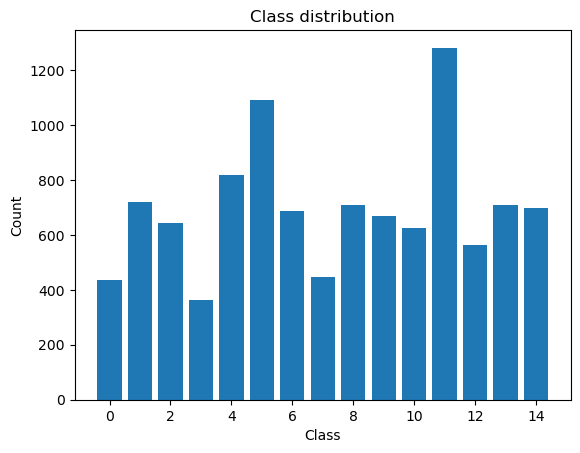

In [33]:
def class_dist(y):
    unique, counts = np.unique(y, return_counts=True)
    plt.bar(unique, counts)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Class distribution")
    plt.show()
class_dist(y_trainval)

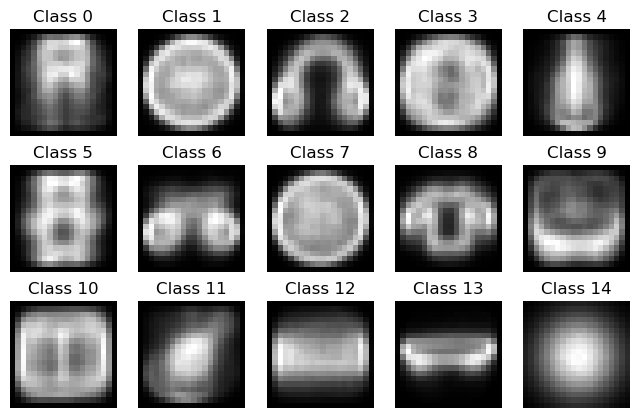

In [32]:
def blurred():
    means = []
    for label in range(15):
        means.append(X_trainval[y_trainval == label].mean(axis=0))

    fig, axes = plt.subplots(3, 5, figsize=(8, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(means[i].reshape(20, 20), cmap='gray')
        ax.set_title(f"Class {i}")
        ax.axis('off')
    plt.show()

blurred()
    #If averages look very similar → classes are visually similar → use a deeper CNN.

    # If they’re very distinct → your model can be smaller (simpler CNN).

# CNN

In [ ]:
param_grid = {
    "learning_rate": [0.001, 0.0005],
    "dropout_rate": [0.25, 0.5],
    "batch_size": [32, 64],
    "weight_decay": [0, 1e-4],
    "random_state": [random_state]
}


grid = GridSearchCV(CNN(), param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=3)
grid.fit(X_trainval_tensor, y_trainval_tensor)

print("Best parameters:", grid.best_params_)

In [ ]:
best_params = grid.best_params_

best_model = CNN(
    num_epochs=20,
    batch_size=best_params["batch_size"],
    learning_rate=best_params["learning_rate"],
    dropout_rate=best_params["dropout_rate"],
    weight_decay=best_params["weight_decay"],
    verbose=True,
    random_state=random_state
)

best_model.fit(X_trainval_tensor, y_trainval_tensor)


In [ ]:
test_acc = best_model.compute_accuracy(test_loader)
y_pred = best_model.predict(X_test_tensor)
test_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nTest Accuracy: {test_acc * 100:.2f}%")
print(f"Weighted F1-score: {test_f1:.4f}")
print(classification_report(y_test, y_pred))

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(best_model.train_loss_history, label='Training Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training Loss Curve')
plt.legend()
plt.show()

# KNN

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

param_grid_knn = {
    'n_neighbors': [2, 3, 4, 5, 6, 7],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
}

knn = KNeighborsClassifier()

grid_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_knn.fit(x_train, y_train)

best_params_knn = grid_knn.best_params_
print(f"Best KNN parameters: {best_params_knn}")

knn = KNeighborsClassifier(**best_params_knn)

knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
score = knn.score(x_test, y_test)
print(f"KNN Classifier score: {score * 100:.2f}%") 

In [ ]:


results = grid_knn.cv_results_
scores = results['mean_test_score']
params = results['params']

df = pd.DataFrame(params)
df['score'] = scores

pivot = df.pivot(index='n_neighbors', columns='metric', values='score')

bubble_to_hot_pink = LinearSegmentedColormap.from_list(
    "bubble_to_hot_pink",
    ["#fec1d9", "#ffa6cb", "#ff82c3", "#ff0080ca"], 
    N=256 
)

plt.figure(figsize=(8, 6))
plt.title("KNN Grid Search Mean F1 Score", fontsize=14)
plt.ylabel("n_neighbors")
plt.xlabel("metric")
plt.show()


In [ ]:
misclassified = np.where(y_pred != y_test)[0]

for idx in misclassified[:10]:
    img = x_test[idx].reshape(20, 20) * 255 
    plt.imshow(img, vmin=0, vmax=255, cmap="gray")
    plt.title(f"True: {y_test[idx]}, Predicted: {y_pred[idx]}")
    plt.show()

# Problem 3

In [ ]:
corrupted_dataset = np.load("dataset_corrupted.npz")
X_corrupted = corrupted_dataset["X"] / 255.0 
X_corrupted_tensor = torch.tensor(X_corrupted, dtype=torch.float32).view(-1, 1, 20, 20)
X_corrupted_tensor = X_corrupted_tensor.to(best_model.device)


best_model.model.eval()
with torch.no_grad():
    outputs = best_model.model(X_corrupted_tensor) 
    probs = F.softmax(outputs, dim=1)  

max_probs = probs.max(dim=1).values

threshold = 0.6

ood_indices = (max_probs < threshold).nonzero(as_tuple=True)[0].cpu().numpy()
print(f"Found {len(ood_indices)} suspicious/corrupted images")

In [ ]:
for idx in ood_indices[:100]:
    plt.imshow(X_corrupted[idx].reshape(20, 20), cmap="gray")
    plt.axis('off')
    plt.show()